# 1.0 Libraries For Preprocessing

In [1]:
# Library for Wrangling and loading
import pandas as pd
import numpy as np

# Libraries for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# Libraries for Partitioning and Spark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import shutil
import hashlib

# Others
import warnings
import os
import time

# Configuration
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

warnings.filterwarnings("ignore")

# 2.0 Partitioning

## 2.1 Partitioning Parameter

In [2]:
N_PARTITION = 50    # Number of buckets
base_partitions_dir = "../data/external/Partition"
output_dir = "../data/external/output"

## 2.2 Collecting data columns

In [3]:
# LOADING PARAMETER
chunksize= 1e5
data_directory = r"..\Data\external\used_cars_data.csv"
# loading chunk of the data for the column list
def col_list(data_path, chunksize, progress=None):
    print("Checking and loading file")
    time.sleep(0.9)
    for df_iter, chunk in enumerate(pd.read_csv(data_path, chunksize=chunksize, iterator=False)):
        pass
    col_list = list(chunk.columns)
    return col_list

## 2.3 Function for Hashing id

In [4]:
# hashing the listing id to allow even partitioning across the dataset
def hash_(listing_id):
    """Creates an hashed column using the listing id for the vehicle"""
    return int(hashlib.md5(str(listing_id).encode("utf-8")).hexdigest(), 16)

## 2.4 Creating dir for partition

In [23]:
def create_partition():
    """Creates an empty partition directory for the buckets"""
    start = time.time()
    print("Checking if the directory exists...")
    time.sleep(0.9)
    if os.path.exists(base_partitions_dir):
        print("Directory found")
        time.sleep(0.4)
        print("Removing directory")
        time.sleep(1)
        shutil.rmtree(base_partitions_dir)
        print("Removed the directory")
    else:
        print("No Such Directory found.")

    # Delaying before creating the directories
    time.sleep(2.5)

    print("Creating empty folder list for partition")
    time.sleep(0.9)
    if not os.path.exists(base_partitions_dir):
        # Creating partition directory
        os.mkdir(base_partitions_dir)
        # Making a new directory for the partitions
        for i in range(N_PARTITION):
            partition_path = os.path.join(
                base_partitions_dir, "p{}".format(i)).replace("\\", "/")
            # Printing the path
            print('| {} | Partition left {} |'.format(partition_path,N_PARTITION-i))
            if not os.path.exists(partition_path):
                os.mkdir(partition_path)
            else:
                print("Path Already exist")
            time.sleep(0.6)
    end = time.time()
    print("| Completed | Time Taken ------------------------- {}sec |".format(str(end-start)))
# Making the directory
dir = create_partition()


Checking if the directory exists...
Directory found
Removing directory
Removed the directory
Creating empty folder list for partition
| ../data/external/Partition/p0 | Partition left 50 |
| ../data/external/Partition/p1 | Partition left 49 |
| ../data/external/Partition/p2 | Partition left 48 |
| ../data/external/Partition/p3 | Partition left 47 |
| ../data/external/Partition/p4 | Partition left 46 |
| ../data/external/Partition/p5 | Partition left 45 |
| ../data/external/Partition/p6 | Partition left 44 |
| ../data/external/Partition/p7 | Partition left 43 |
| ../data/external/Partition/p8 | Partition left 42 |
| ../data/external/Partition/p9 | Partition left 41 |
| ../data/external/Partition/p10 | Partition left 40 |
| ../data/external/Partition/p11 | Partition left 39 |
| ../data/external/Partition/p12 | Partition left 38 |
| ../data/external/Partition/p13 | Partition left 37 |
| ../data/external/Partition/p14 | Partition left 36 |
| ../data/external/Partition/p15 | Partition left 3

## 2.5 Creating blank partition

In [24]:
chunksize= 1e5
data_directory = r"..\Data\external\used_cars_data.csv"
def create_blank_partition():
    """Creating a blank partition with the number of bucket"""
    start = time.time()
    data_list = col_list(data_directory, chunksize)
    for i in range(N_PARTITION):
        time.sleep(0.9)
        file_base_dir = os.path.join(base_partitions_dir,"p{}".format(str(i)),"").replace("\\","/")
        print(file_base_dir)
        # Opening the file and writing it to the partition created
        with open(file_base_dir+"vehicle_used_data.csv", "w") as f:
            f.write(",".join(data_list))
    end = time.time()
    print("Time taken ------------------- | {}sec".format(str(end-start)))
    return file_base_dir

dir_path = create_blank_partition()

Checking and loading file
../data/external/Partition/p0/
../data/external/Partition/p1/
../data/external/Partition/p2/
../data/external/Partition/p3/
../data/external/Partition/p4/
../data/external/Partition/p5/
../data/external/Partition/p6/
../data/external/Partition/p7/
../data/external/Partition/p8/
../data/external/Partition/p9/
../data/external/Partition/p10/
../data/external/Partition/p11/
../data/external/Partition/p12/
../data/external/Partition/p13/
../data/external/Partition/p14/
../data/external/Partition/p15/
../data/external/Partition/p16/
../data/external/Partition/p17/
../data/external/Partition/p18/
../data/external/Partition/p19/
../data/external/Partition/p20/
../data/external/Partition/p21/
../data/external/Partition/p22/
../data/external/Partition/p23/
../data/external/Partition/p24/
../data/external/Partition/p25/
../data/external/Partition/p26/
../data/external/Partition/p27/
../data/external/Partition/p28/
../data/external/Partition/p29/
../data/external/Partiti

## 2.6 Partitioning by hashing

In [4]:
N_PARTITION = 50    # Number of buckets
# Partitioing and hashing the 
def partition_by_hashing(df, progress=None):
    # hashing the listing_id column into the number of partitions
    df["hashed"] = df["listing_id"].apply(hash_) % N_PARTITION
    for partitions, data in df.groupby("hashed"):
        start = time.time()
        print("Data partition: {}".format(str(partitions)))
        # Removing hash columns from the dataset
        data = data.drop("hashed", axis=1)
        # Wrting the data to the partition
        path_dir = os.path.join(base_partitions_dir,"p{}".format(partitions),"").replace("\\","/")
        print("| writing data partition to {} |".format(path_dir))
        # Writing the data to the path
        with open(path_dir+"vehicle_used_data.csv", "a", encoding="utf-8") as f:
            f.write("\n")
            data.to_csv(f, header=False, index=False)
            
        end = time.time()
        print("Time taken {}sec".format(str(end-start)))
    

## 2.7 Writing data to each partition

In [26]:
chunksize = 1e5
for df_iter, data in enumerate(pd.read_csv(r"..\Data\external\used_cars_data.csv", iterator=True, chunksize=chunksize, encoding="latin1"),1):
    print("Iter:",df_iter)
    partition = partition_by_hashing(df=data)
    print("\n")
    #data = partition_by_hashing(df, name="listing_id", progress=None)
    

Iter: 1


Data partition: 0
| writing data partition to ../data/external/Partition/p0/ |
Time taken 1.7771995067596436sec
Data partition: 1
| writing data partition to ../data/external/Partition/p1/ |
Time taken 0.3827812671661377sec
Data partition: 2
| writing data partition to ../data/external/Partition/p2/ |
Time taken 0.4177563190460205sec
Data partition: 3
| writing data partition to ../data/external/Partition/p3/ |
Time taken 0.45574069023132324sec
Data partition: 4
| writing data partition to ../data/external/Partition/p4/ |
Time taken 0.3867764472961426sec
Data partition: 5
| writing data partition to ../data/external/Partition/p5/ |
Time taken 0.3787803649902344sec
Data partition: 6
| writing data partition to ../data/external/Partition/p6/ |
Time taken 0.40177106857299805sec
Data partition: 7
| writing data partition to ../data/external/Partition/p7/ |
Time taken 0.47272825241088867sec
Data partition: 8
| writing data partition to ../data/external/Partition/p8/ |
Time taken 0

# 3.0 Data Distribution with Spark

 ## 3.1 Data cleaning in parallel(configuration)

# 4.0 Data Cleaning

## 4.1 Loading first Partition

In [4]:
# LOADING FIRST PARTITION FILE
PARTITION = 0
TARGET = "price"
PARTITION_DIR = os.path.join("..\Data\external\Partition", "p{}".format(str(PARTITION)),"vehicle_used_data.csv").replace("\\","/")

used_data = pd.read_csv(PARTITION_DIR, header=0, delimiter=",")
used_data.head(2)

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,daysonmarket,dealer_zip,description,engine_cylinders,engine_displacement,engine_type,exterior_color,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,highway_fuel_economy,horsepower,interior_color,isCab,is_certified,is_cpo,is_new,is_oemcpo,latitude,length,listed_date,listing_color,listing_id,longitude,main_picture_url,major_options,make_name,maximum_seating,mileage,model_name,owner_count,power,price,salvage,savings_amount,seller_rating,sp_id,sp_name,theft_title,torque,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,1GNERGKW2JJ194328,38.4 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bay Shore,18.0,NaN,83,11706,"Here at Atlantic Chevrolet-Cadillac, 90% of ou...",V6,3600.0,V6,Satin Steel Metallic,False,False,True,Chevrolet,41 in,19.4 gal,Gasoline,False,70.7 in,27.0,310.0,Dark Atmosphere/Medium Ash Gray,False,NaN,True,False,True,40.7333,204.3 in,2020-06-18,UNKNOWN,274409090,-73.2587,https://static.cargurus.com/images/forsale/202...,"['Driver Confidence Package', 'Power Package',...",Chevrolet,8 seats,29695.0,Traverse,1.0,"310 hp @ 6,800 RPM",26343.0,False,1685,3.447761,314501.0,Atlantic Chevrolet Cadillac,False,"266 lb-ft @ 2,800 RPM",A,9-Speed Automatic,t73662,LT Cloth FWD,NaN,FWD,Front-Wheel Drive,120.9 in,78.6 in,2018
1,1C4RDJEG9HC611713,38.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bronx,18.0,NaN,66,10466,FACTORY CERTIFIED WARRANTY AVAILABLE THROUGH 2...,V6,3600.0,V6,White Knuckle Clearcoat,False,False,True,Dodge,40.3 in,24.6 gal,Gasoline,False,70.9 in,25.0,295.0,Sepia/Black,False,NaN,True,False,True,40.8847,201.2 in,2020-07-05,WHITE,275894461,-73.8317,https://static.cargurus.com/images/forsale/202...,"['Leather Seats', 'Sunroof/Moonroof', 'Navigat...",Dodge,7 seats,65508.0,Durango,1.0,"360 hp @ 5,150 RPM",27200.0,False,965,2.800000,62178.0,Eastchester Chrysler Jeep Dodge Ram,False,"390 lb-ft @ 4,250 RPM",A,8-Speed Automatic,t68694,Citadel AWD,NaN,AWD,All-Wheel Drive,119.8 in,85.5 in,2017


In [5]:
data = used_data.copy()

In [7]:
def clean_data(data):
    """Removing some irrelevant columns in the dataframe"""

    # Defining some columns to remove
    cols = ["vin", 'description', "exterior_color", "wheel_system", "vehicle_damage_category", "trimId",
            "theft_title", "sp_id", "main_picture_url", "longitude", "listing_id", "listing_color", "latitude",
                "interior_color", "cabin", "major_options", "back_legroom", "bed", "bed_height", "bed_length", "is_certified","owner_count",
                    "is_cpo", "is_oemcpo", "salvage", "wheelbase", "width","combine_fuel_economy","daysonmarket","dealer_zip","engine_cylinders","horsepower",
                    "franchise_dealer","front_legroom","fuel_tank_volume","height","length","franchise_make","savings_amount","transmission_display","trim_name","sp_name"
                    ]
    # Dropping the columns
    data = data.drop(columns=cols)
    # data = data.drop(cols, axis=1)
    
    # listed date to pandas datetime
    data["listed_date"] = pd.to_datetime(data["listed_date"])
    
    # Transforming
    data["transmission"] = data["transmission"].apply(lambda inf: str(inf).replace("A","Automatic").replace("M","Manual"))
    data["Vehicle_power"] = data["power"].apply(lambda inf: str(inf).split("@")[0].strip().split(" ")[0])
    data["Vehicle_torque"] = data["torque"].apply(lambda inf: str(inf).split("@")[0].strip().split(" ")[0])
    data["max_seating"] = data["maximum_seating"].apply(lambda inf: str(inf).strip().split(" ")[0])
    data["Listing_year"] = data["listed_date"].apply(lambda inf: inf.year)
    data["engine_displacement"] = data["engine_displacement"].apply(lambda inf: inf/1000)
    data["combined_MPG"] = (data["highway_fuel_economy"] + data["city_fuel_economy"])/2
    
    # Replacing any "nan" with np.nan value ===> Null
    data = data.replace({"nan":np.nan, "_": np.nan,"--":np.nan})
    
    # Changing datatype
    data["Vehicle_power"] = data['Vehicle_power'].astype(np.float).astype("Int32")
    data["Vehicle_torque"] = data['Vehicle_torque'].astype(np.float).astype("Int32")
    data["max_seating"] = data['max_seating'].astype(np.float).astype("Int32")


    # data["isCab"] = pd.DataFrame(data["isCab"])
    # data["isCab"] = data["isCab"].map({"False":False,"True":True})
    
    
    # Dropping some more columns
    data = data.drop(columns=["listed_date","maximum_seating","power",'torque'])
    # Renaming some columns
    data = data.rename(columns={"wheel_system_display":"Drivetrain",
                                "transmission":"Transmission",
                                "body_type":"body_style",
                                "city_fuel_economy":"city_MPG",
                                "engine_displacement":"engine_size",
                                "highway_fuel_economy":"highway_MPG",
                                "year": "Vehicle_year"})
    
    
    return data
    

In [8]:
new_data = clean_data(data)
new_data.head(2)

,body_style,city,city_MPG,engine_size,engine_type,fleet,frame_damaged,fuel_type,has_accidents,highway_MPG,isCab,is_new,make_name,mileage,model_name,price,seller_rating,Transmission,Drivetrain,Vehicle_year,Vehicle_power,Vehicle_torque,max_seating,Listing_year,combined_MPG
0,SUV / Crossover,Bay Shore,18.0,3.6,V6,False,False,Gasoline,False,27.0,False,False,Chevrolet,29695.0,Traverse,26343.0,3.447761,Automatic,Front-Wheel Drive,2018,310,266,8,2020,22.5
1,SUV / Crossover,Bronx,18.0,3.6,V6,False,False,Gasoline,False,25.0,False,False,Dodge,65508.0,Durango,27200.0,2.800000,Automatic,All-Wheel Drive,2017,360,390,7,2020,21.5


In [57]:
missing_fea = [feature for feature in new_data.columns if new_data[feature].isnull().sum() >0 and new_data[feature].dtype == "O"]
missing_fea

['body_style',
 'engine_type',
 'fleet',
 'frame_damaged',
 'fuel_type',
 'has_accidents',
 'isCab',
 'Transmission',
 'Drivetrain']

## Dealing with the missing values

In [46]:
def impute_missing_values(new_data,verbose: int):
    """Dealing with the missing values by imputation"""
    # Performing input validation
    if (verbose != int or verbose not in [0,1]):
        raise TypeError("Code ran into an Exception \
                        Because verbose is either a string or not 0 or 1")
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import LabelEncoder
    cat_missing_fea = [feature for feature in new_data.columns if new_data[feature].isnull().sum() >0 and new_data[feature].dtype == object]
    num_missing_fea = [feature for feature in new_data.columns if new_data[feature].isnull().sum() >0 and new_data[feature].dtype != object]
    feature = [feature for feature in new_data.columns if new_data[feature].isnull().sum() == 0]
    
    # Label encoding the categorical feature
    le = LabelEncoder()
    for feature in cat_missing_fea:
        new_data[feature] = le.fit_transform(new_data[feature])
    # imputing the missing features
    estimator = RandomForestRegressor(random_state=42)
    imputer = IterativeImputer(
        estimator=estimator, max_iter=7,verbose=1,random_state=42
    )
    transformed = imputer.fit_transform(new_data)
    transformed_data = pd.DataFrame(transformed, columns=new_data.columns)
    
    # Inversing the encoded cat features
    for feature in cat_missing_fea:
        new_data[feature] = le.inverse_transform(new_data[feature])
    
    return transformed_data

In [27]:
new_data.isnull().sum()

body_style          276
city                  0
city_MPG          10046
engine_size        3487
engine_type        2088
fleet             28630
frame_damaged     28630
fuel_type          1740
has_accidents     28630
highway_MPG       10046
isCab             28630
is_new                0
make_name             0
mileage            2930
model_name            0
price                 0
seller_rating       844
Transmission       1279
Drivetrain         3002
Vehicle_year          0
Vehicle_power      9724
Vehicle_torque    10438
max_seating        3271
Listing_year          0
combined_MPG      10046
dtype: int64

In [51]:
new_data["make_name"].nunique()

57

ValueError: shape mismatch: objects cannot be broadcast to a single shape

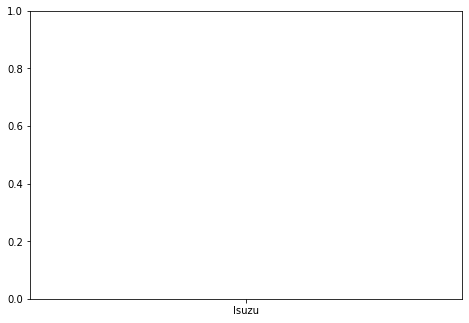

In [47]:
fig = plt.figure()
axis = fig.add_axes([0,0,1,1])
axis.bar(new_data.groupby("make_name")["price"].mean().sort_values().index,new_data.groupby("body_style")["price"].mean().sort_values().values)
plt.title('Price based on the body style')
plt.xlabel(xlabel= axis.get_xlabel(),rotation=45, horizontalalignment="right")
plt.show()

In [12]:
new_data.isnull().sum()

body_style          276
city                  0
city_MPG          10046
engine_size        3487
engine_type        2088
fleet             28630
frame_damaged     28630
fuel_type          1740
has_accidents     28630
highway_MPG       10046
isCab             28630
is_new                0
make_name             0
mileage            2930
model_name            0
price                 0
seller_rating       844
Transmission       1279
Drivetrain         3002
Vehicle_year          0
Vehicle_power      9724
Vehicle_torque    10438
max_seating        3271
Listing_year          0
combined_MPG      10046
dtype: int64

In [2]:
# SPARK PARAMETER

SPARK_HOME = r"C:\spark\spark" # The spark location
LOG_DIR = r"C:\Users\PSALISHOL\AppData\Local\Temp\eventlogging" # Eventlogging location

import findspark
findspark.init()

# Spark configuration
import pyspark
conf = pyspark.SparkConf()

# Enabling logging
conf.set("spark.eventLog.enabled", True)
conf.set("spark.eventLog.dir", LOG_DIR)


# Enabling all cores usage
conf.set("spark.num.executor", 1)
conf.set("spark.executor.memory", "8g")
conf.set("spark.executor.cores",2)

# Set parent
conf.set("spark.master", "local[2]")
conf.getAll()


sc = pyspark.SparkContext(appName=("DataCleaning"), conf=conf)
sc

Exception: Java gateway process exited before sending its port number

In [17]:
# Parallelizing the process
start = time.time()
sc.parallelize(list(range(0, N_PARTITION)),numSlices=3).map(lambda x: clean_data(x)).collect()
sc.stop()
end = time.time()
sc.close()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 1.0 failed 1 times, most recent failure: Lost task 1.0 in stage 1.0 (TID 4) (DESKTOP-6K10A22 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\PSALISHOL\Desktop\spark\spark-3.2.0-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\worker.py", line 619, in main
  File "C:\Users\PSALISHOL\Desktop\spark\spark-3.2.0-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\worker.py", line 611, in process
  File "C:\Users\PSALISHOL\Desktop\spark\spark-3.2.0-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "C:\Users\PSALISHOL\Desktop\spark\spark-3.2.0-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "C:\Users\PSALIS~1\AppData\Local\Temp/ipykernel_4768/3669444643.py", line 3, in <lambda>
  File "C:\Users\PSALIS~1\AppData\Local\Temp/ipykernel_4768/593887780.py", line 12, in clean_data
AttributeError: 'int' object has no attribute 'drop'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:545)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:703)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:685)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:498)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2352)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2351)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2351)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1109)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2591)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2533)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2522)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:898)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\PSALISHOL\Desktop\spark\spark-3.2.0-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\worker.py", line 619, in main
  File "C:\Users\PSALISHOL\Desktop\spark\spark-3.2.0-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\worker.py", line 611, in process
  File "C:\Users\PSALISHOL\Desktop\spark\spark-3.2.0-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "C:\Users\PSALISHOL\Desktop\spark\spark-3.2.0-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "C:\Users\PSALIS~1\AppData\Local\Temp/ipykernel_4768/3669444643.py", line 3, in <lambda>
  File "C:\Users\PSALIS~1\AppData\Local\Temp/ipykernel_4768/593887780.py", line 12, in clean_data
AttributeError: 'int' object has no attribute 'drop'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:545)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:703)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:685)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:498)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


In [3]:
new_data = clean_data(data)

NameError: name 'clean_data' is not defined